# Data Processing and Exploratory Data Analysis

## Risk-Aware Material Allocation Optimization
**Group 7**

This notebook performs a detailed exploratory data analysis on:
- Retail demand data (FreshRetailNet via Hugging Face)
- Supply chain logistics data (synthetic)

**Objectives:**

1. To extract meaningful insights on demand variability,
supply-side risk, and their interaction to inform downstream simulation
and optimization.

2. To load and merge demand + supply chain datasets to create a unified plant-level view for material allocation optimization.

---


## 1. Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete!")

Setup complete!


## 2. Load Datasets

In [ ]:

# Load demand data (FreshRetailNet)
demand_df = pd.read_csv('../large/freshretailnet_full.csv')

# Load supply chain logistics data
supply_df = pd.read_csv('../data/dynamic_supply_chain_logistics_dataset.csv')

print(f"Demand data: {demand_df.shape[0]:,} rows, {demand_df.shape[1]} columns")
print(f"Supply data: {supply_df.shape[0]:,} rows, {supply_df.shape[1]} columns")


Demand data: 4,500,000 rows, 19 columns
Supply data: 32,065 rows, 26 columns


## 3. General EDA

### Data Schema and Basic Structure

In [4]:
# Convert date columns
demand_df["dt"] = pd.to_datetime(demand_df["dt"])
supply_df["timestamp"] = pd.to_datetime(supply_df["timestamp"])

print(demand_df.dtypes)
print(supply_df.dtypes)

city_id                         int64
store_id                        int64
management_group_id             int64
first_category_id               int64
second_category_id              int64
third_category_id               int64
product_id                      int64
dt                     datetime64[ns]
sale_amount                   float64
hours_sale                     object
stock_hour6_22_cnt              int64
hours_stock_status             object
discount                      float64
holiday_flag                    int64
activity_flag                   int64
precpt                        float64
avg_temperature               float64
avg_humidity                  float64
avg_wind_level                float64
dtype: object
timestamp                          datetime64[ns]
vehicle_gps_latitude                      float64
vehicle_gps_longitude                     float64
fuel_consumption_rate                     float64
eta_variation_hours                       float64
traffic_conges

Number of days: 90


dt
2024-03-28    35787.337
2024-03-29    34893.476
2024-03-30    47995.157
2024-03-31    49950.534
2024-04-01    35607.989
Name: sale_amount, dtype: float64

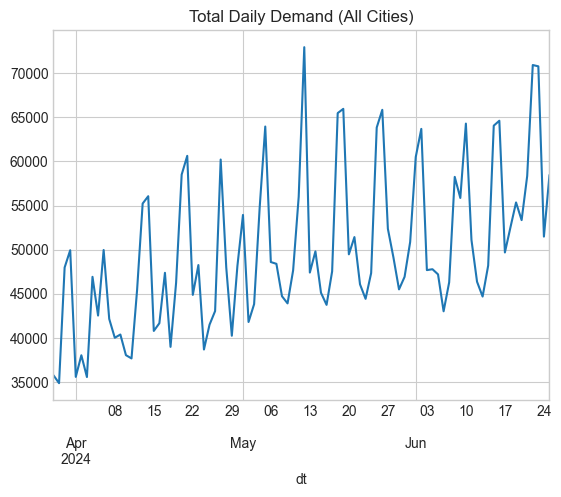

In [5]:
# Global daily demand
daily_demand = demand_df.groupby("dt")["sale_amount"].sum()

print("Number of days:", daily_demand.shape[0])
display(daily_demand.head())

daily_demand.plot(title="Total Daily Demand (All Cities)")
plt.show()

### Demand Hierarchy and Feasibility

In [6]:
print("Unique cities:", demand_df["city_id"].nunique())
print("Unique stores:", demand_df["store_id"].nunique())
print("Unique products:", demand_df["product_id"].nunique())
print("Date range:", demand_df["dt"].min(), "to", demand_df["dt"].max())

Unique cities: 18
Unique stores: 898
Unique products: 865
Date range: 2024-03-28 00:00:00 to 2024-06-25 00:00:00


**Insight:**
Cities (18) provide a clean and defensible proxy for plants in a multi-plant
allocation setting.

### Aggregation-First Demand Analysis

**Insight:**
Demand shows strong volatility and spikes, indicating that average-based
planning would underestimate risk.

In [7]:
city_daily = (
    demand_df
    .groupby(["dt", "city_id"])["sale_amount"]
    .sum()
    .reset_index()
)

print(
    city_daily
    .groupby("city_id")["sale_amount"]
    .std()
    .describe()
)

count      18.000000
mean      516.676411
std       996.912011
min        11.316237
25%        86.327537
50%       126.765121
75%       485.844642
max      4331.895035
Name: sale_amount, dtype: float64


**Insight:**
Demand variability differs significantly across cities, motivating
plant-specific buffers or risk adjustments.

### Retail Dataset Structure Observations

- The retail dataset contains transactional sales records with identifiers for **store, product, and city**, along with calendar and weather-related features.
- A clear **date column (`dt`)** is present, enabling temporal ordering and time-based analysis.
- The primary demand signal is captured through the **sale_amount** field.
- Stock availability and stockout behavior are represented using **stock_hour6_22_cnt** and related fields.
- All required variables for demand forecasting and downstream aggregation are present in the dataset.

### Logistics Dataset Structure Observations

- The logistics dataset consists of operational records with cost, lead time, and multiple risk-related indicators.
- Transportation cost, lead time, delay probability, and route risk variables are available in numeric form.
- The dataset does not contain explicit source–destination plant identifiers, indicating it is intended for parameter estimation rather than direct joining.
- These variables are suitable for aggregation into average or scenario-based parameters for optimization modeling.


## 4. Explore Demand Data (FreshRetailNet)

In [8]:
print("=" * 60)
print("DEMAND DATA - FreshRetailNet")
print("=" * 60)
display(demand_df.head())

print("\nColumn types:")
print(demand_df.dtypes)

DEMAND DATA - FreshRetailNet


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.1,[0. 0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0...,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.1,[0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0. 0...,1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1],1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.1,[0. 0. 0. 0. 0. 0. 0. 0. 0.1 0. 0. 0...,11,[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1],1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.2,[0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0. 0...,8,[1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1],1.0,0,0,3.5386,15.37,78.26,1.25



Column types:
city_id                         int64
store_id                        int64
management_group_id             int64
first_category_id               int64
second_category_id              int64
third_category_id               int64
product_id                      int64
dt                     datetime64[ns]
sale_amount                   float64
hours_sale                     object
stock_hour6_22_cnt              int64
hours_stock_status             object
discount                      float64
holiday_flag                    int64
activity_flag                   int64
precpt                        float64
avg_temperature               float64
avg_humidity                  float64
avg_wind_level                float64
dtype: object


In [9]:
# Key dimensions for "plants"
print("--- Plant Hierarchy ---")
print(f"Unique cities (city_id): {demand_df['city_id'].nunique()}")
print(f"Unique stores (store_id): {demand_df['store_id'].nunique()}")
print(f"Unique products (product_id): {demand_df['product_id'].nunique()}")
print(f"Date range: {demand_df['dt'].min()} to {demand_df['dt'].max()}")


--- Plant Hierarchy ---
Unique cities (city_id): 18
Unique stores (store_id): 898
Unique products (product_id): 865
Date range: 2024-03-28 00:00:00 to 2024-06-25 00:00:00


In [10]:
retail_df = demand_df

### Temporal Coverage

In [11]:
# Converting dt to datetime
retail_df["dt"] = pd.to_datetime(retail_df["dt"])

# Basic temporal coverage
print("Start date:", retail_df["dt"].min())
print("End date:", retail_df["dt"].max())
print("Number of unique dates:", retail_df["dt"].nunique())

# Checking if multiple records per store-product-date exist
records_per_day = (
    retail_df
    .groupby(["store_id", "product_id", "dt"])
    .size()
    .reset_index(name="records_per_day")
)

records_per_day["records_per_day"].value_counts()

Start date: 2024-03-28 00:00:00
End date: 2024-06-25 00:00:00
Number of unique dates: 90


records_per_day
1    4500000
Name: count, dtype: int64

**Observations:**. 

The data spans a continuous range of dates with no obvious gaps, and each store–product–date combination appears only once. This means we don’t need to do any hourly-to-daily aggregation, which simplifies things a lot. Daily demand seems like the right level to work with, especially since transportation and inventory decisions are not made at an hourly level anyway.

### Demand Distribution

count    4.500000e+06
mean     9.985913e-01
std      1.406738e+00
min      0.000000e+00
25%      4.000000e-01
50%      7.000000e-01
75%      1.100000e+00
max      4.490000e+01
Name: sale_amount, dtype: float64

Zero Sales: 200760
Total Rows: 4500000


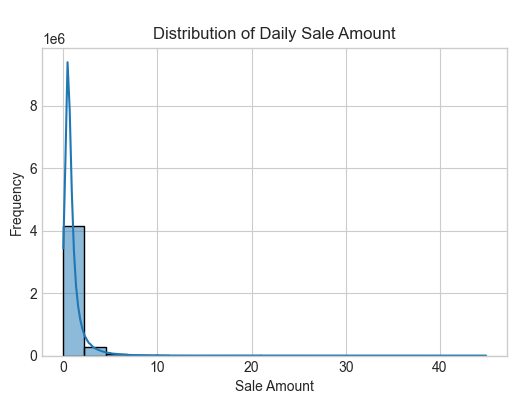

In [12]:
# Basic descriptive statistics for demand
print(retail_df["sale_amount"].describe())

# Check for zero or near-zero demand
print(f"\nZero Sales: {(retail_df['sale_amount'] == 0).sum()}\nTotal Rows: {retail_df.shape[0]}")

# Demand distribution visualization
plt.figure(figsize=(6,4))
sns.histplot(retail_df["sale_amount"], bins=20, kde=True)
plt.title("\nDistribution of Daily Sale Amount")
plt.xlabel("Sale Amount")
plt.ylabel("Frequency")
plt.show()

**Observations:**. 

Demand is generally very low on most days, with a large number of zero-sale records. At the same time, there are occasional days with much higher sales, which creates a long right tail in the distribution.

This tells us two things:

- demand is not smooth or stable,

- simple averages alone won’t capture what’s really going on.

This kind of pattern feels realistic for retail data but also means forecasting won’t be trivial.

### Store-Level and Product-Level Variability

         store_id  total_sale_amount
count  898.000000         898.000000
mean   448.500000        5004.076600
std    259.374568        3123.548706
min      0.000000          51.100000
25%    224.250000        2767.965000
50%    448.500000        4448.404500
75%    672.750000        6742.974750
max    897.000000       17510.530000
Unique stores (store_id): 898


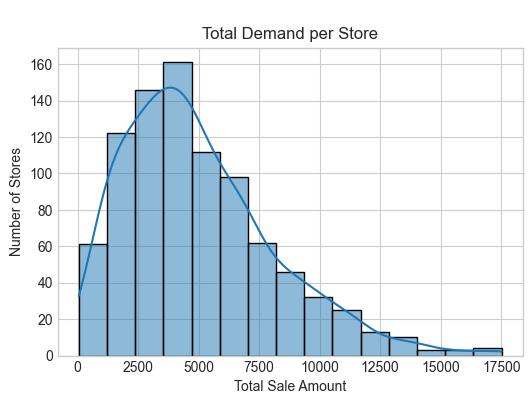

In [13]:
# Aggregating total demand by store
store_demand = (
    retail_df
    .groupby("store_id")["sale_amount"]
    .sum()
    .reset_index()
    .rename(columns={"sale_amount": "total_sale_amount"})
)

print(store_demand.describe())

print(f"Unique stores (store_id): {retail_df['store_id'].nunique()}")

# Visualizing store-level demand distribution
plt.figure(figsize=(6,4))
sns.histplot(store_demand["total_sale_amount"], bins=15, kde=True)
plt.title("\nTotal Demand per Store")
plt.xlabel("Total Sale Amount")
plt.ylabel("Number of Stores")
plt.show()

       product_id  total_sale_amount
count  865.000000         865.000000
mean   432.000000        5194.983569
std    249.848287       16121.895486
min      0.000000          33.370000
25%    216.000000         119.900000
50%    432.000000         582.540000
75%    648.000000        3395.420000
max    864.000000      183395.100000


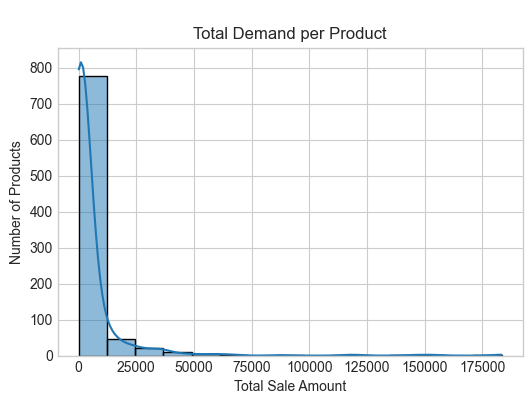

In [14]:
# Aggregate total demand by product
product_demand = (
    retail_df
    .groupby("product_id")["sale_amount"]
    .sum()
    .reset_index()
    .rename(columns={"sale_amount": "total_sale_amount"})
)

print(product_demand.describe())

# Visualize product-level demand distribution
plt.figure(figsize=(6,4))
sns.histplot(product_demand["total_sale_amount"], bins=15, kde=True)
plt.title("\nTotal Demand per Product")
plt.xlabel("Total Sale Amount")
plt.ylabel("Number of Products")
plt.show()

**Observation:** 

When we aggregate demand by store, we see clear differences across stores. Some stores consistently sell much more than others, while many fall into a mid-to-low range. Demand is not evenly distributed, so treating all stores as “similar” would hide useful information.

At the product level, the imbalance is even stronger. A small number of products account for a very large share of total sales, while most products sell very little overall. This looks like a classic long-tail pattern.

Because of this, it probably doesn’t make sense to model all products equally. Focusing on higher-volume products should make the models more stable and easier to interpret without losing much business relevance.

### Stockout Behavior & Context Signals

In [15]:
# Basic stockout statistics
print(retail_df["stock_hour6_22_cnt"].describe())

# Proportion of days with stockouts
stockout_days = (retail_df["stock_hour6_22_cnt"] > 0).sum()
total_days = retail_df.shape[0]

print(f"\nDays with stockouts: {stockout_days}")
print(f"Total records: {total_days}")
print(f"\033[1mStockout rate:\033[0m {stockout_days / total_days:.2%}")

# Comparing demand on stockout vs non-stockout days
print("\n", retail_df.groupby(retail_df["stock_hour6_22_cnt"] > 0)["sale_amount"].describe())

# Demand by discount presence
print("\033[1m\nDemand by discount presence:\033[0m ", retail_df.groupby(retail_df["discount"] > 0)["sale_amount"].mean())

# Demand by holiday flag
print("\033[1m\nDemand by holiday flag:\033[0m ", retail_df.groupby("holiday_flag")["sale_amount"].mean())

# Demand by activity flag
print("\033[1m\nDemand by activity flag:\033[0m ", retail_df.groupby("activity_flag")["sale_amount"].mean())

count    4.500000e+06
mean     3.180341e+00
std      4.596586e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
max      1.600000e+01
Name: stock_hour6_22_cnt, dtype: float64

Days with stockouts: 1992006
Total records: 4500000
Stockout rate: 44.27%

                         count      mean       std  min  25%   50%  75%   max
stock_hour6_22_cnt                                                          
False               2507994.0  0.974518  1.275829  0.0  0.4  0.68  1.1  44.9
True                1992006.0  1.028900  1.555442  0.0  0.4  0.70  1.1  40.4

Demand by discount presence:  discount
False    14.475037
True      0.950386
Name: sale_amount, dtype: float64

Demand by holiday flag:  holiday_flag
0    0.913969
1    1.159647
Name: sale_amount, dtype: float64

Demand by activity flag:  activity_flag
0    0.989662
1    1.013258
Name: sale_amount, dtype: float64


#### Stockout Behavior

Stockouts show up a lot in the data, roughly 4 out of every 10 records have at least some stockout hours.

On many days there are no stockouts at all, but when they do happen, they often last for multiple hours.

This means a decent chunk of sales data is likely affected by products simply not being available.

Because of how common this is, stockouts can’t really be treated as edge cases or noise.

#### Demand vs Stockouts

When we compare sales on stockout days versus non-stockout days, the average sales numbers are surprisingly similar.

This likely means sales are being capped by availability and low sales don’t necessarily mean low demand.

In other words, we’re probably not seeing the full demand signal on stockout days.

Because of this, stockouts make more sense to handle later as limits or penalties in the allocation logic rather than as demand signals themselves.

#### Context Signals (Holidays, Activity, Discounts)

Holidays clearly stand out since average sales are higher on holiday days, which lines up with expectations.

Activity-related flags also show a small lift in demand, though the effect is not very strong.

Discounts don’t show a clear positive impact on sales in this data. This could be because discounts are applied when inventory is already tight or in response to slow movement.

Overall, holidays and activity seem worth keeping as demand signals, while discounts should be used carefully and not assumed to always increase sales.

## 5. Explore Supply Chain (Logistics) Data


In [16]:
print("=" * 60)
print("SUPPLY CHAIN LOGISTICS DATA")
print("=" * 60)
display(supply_df.head())

print("\nKey metrics summary:")
display(supply_df[['warehouse_inventory_level', 'lead_time_days', 'shipping_costs', 
                   'delay_probability', 'delivery_time_deviation']].describe())

print("\nRisk Classification:")
print(supply_df['risk_classification'].value_counts())


SUPPLY CHAIN LOGISTICS DATA


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,0.742735,3.818972,2530.431941,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,0.431088,14.001491,2146.190197,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484



Key metrics summary:


,warehouse_inventory_level,lead_time_days,shipping_costs,delay_probability,delivery_time_deviation
count,3.206500e+04,32065.000000,32065.000000,32065.000000,32065.000000
mean,2.992547e+02,5.227502,459.374452,0.699077,5.177648
std,3.234435e+02,4.523085,312.183487,0.324514,4.157988
min,1.322210e-12,1.000000,100.000000,0.000003,-1.999998
25%,1.605163e+01,1.237490,154.017124,0.456009,1.269197
50%,1.572880e+02,3.297654,388.996911,0.839599,6.113662
75%,5.405980e+02,8.625720,753.007203,0.982391,9.249206
max,9.999993e+02,14.999995,999.999853,1.000000,10.000000



Risk Classification:
risk_classification
High Risk        23944
Moderate Risk     5011
Low Risk          3110
Name: count, dtype: int64


### Missing Value Analysis

In [17]:
missing = supply_df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(supply_df) * 100).round(2)

missing_table = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
missing_table[missing_table["missing_count"] > 0]


,missing_count,missing_pct


No Missing values!

### Duplicate Records Check

In [18]:
dup_count = supply_df.duplicated().sum()
dup_count

np.int64(0)

No Duplicates found!

### Parse timestamp + create time features

In [19]:
supply_df["timestamp"] = pd.to_datetime(supply_df["timestamp"], errors="coerce")

supply_df["date"] = supply_df["timestamp"].dt.date
supply_df["hour"] = supply_df["timestamp"].dt.hour
supply_df["dayofweek"] = supply_df["timestamp"].dt.dayofweek  # Mon=0
supply_df["month"] = supply_df["timestamp"].dt.month

supply_df[["timestamp","date","hour","dayofweek","month"]].head()


,timestamp,date,hour,dayofweek,month
0,2021-01-01 00:00:00,2021-01-01,0,4,1
1,2021-01-01 01:00:00,2021-01-01,1,4,1
2,2021-01-01 02:00:00,2021-01-01,2,4,1
3,2021-01-01 03:00:00,2021-01-01,3,4,1
4,2021-01-01 04:00:00,2021-01-01,4,4,1


### Descriptive Statistics (Numerical Features)

In [20]:
num_cols = supply_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = supply_df.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))
num_cols, cat_cols


Numeric columns: 27
Categorical columns: 3


(['vehicle_gps_latitude',
  'vehicle_gps_longitude',
  'fuel_consumption_rate',
  'eta_variation_hours',
  'traffic_congestion_level',
  'warehouse_inventory_level',
  'loading_unloading_time',
  'handling_equipment_availability',
  'order_fulfillment_status',
  'weather_condition_severity',
  'port_congestion_level',
  'shipping_costs',
  'supplier_reliability_score',
  'lead_time_days',
  'historical_demand',
  'iot_temperature',
  'cargo_condition_status',
  'route_risk_level',
  'customs_clearance_time',
  'driver_behavior_score',
  'fatigue_monitoring_score',
  'disruption_likelihood_score',
  'delay_probability',
  'delivery_time_deviation',
  'hour',
  'dayofweek',
  'month'],
 ['timestamp', 'risk_classification', 'date'])

**Explanation:**
Descriptive statistics help understand:
- Demand volatility
- Inventory imbalance
- Cost ranges
- Lead-time uncertainty
These insights directly inform optimization constraints.


In [21]:
supply_df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
vehicle_gps_latitude,32065.0,38.023589,6.917909,3.000000e+01,31.280550,36.413820,44.453655,50.000000
vehicle_gps_longitude,32065.0,-90.116648,17.369244,-1.200000e+02,-106.253913,-86.293414,-73.079367,-70.000000
fuel_consumption_rate,32065.0,8.011735,4.264960,5.000000e+00,5.019984,5.636036,9.669944,19.999875
eta_variation_hours,32065.0,2.893068,2.274044,-1.999993e+00,1.185744,3.882059,4.884355,5.000000
traffic_congestion_level,32065.0,4.991493,3.532048,1.091633e-09,1.474720,4.981244,8.534902,9.999999
warehouse_inventory_level,32065.0,299.254732,323.443513,1.322210e-12,16.051635,157.288022,540.597991,999.999298
loading_unloading_time,32065.0,2.291669,1.554202,5.000000e-01,0.774798,1.917121,3.734188,5.000000
handling_equipment_availability,32065.0,0.302695,0.325915,4.565769e-16,0.017108,0.159515,0.553595,0.999999
order_fulfillment_status,32065.0,0.600740,0.345672,1.317764e-06,0.277096,0.680553,0.938160,1.000000
weather_condition_severity,32065.0,0.497608,0.353285,4.536949e-09,0.144014,0.496178,0.849823,1.000000


### Categorical value counts (important for status/risk labels)

In [22]:
for c in ["order_fulfillment_status", "cargo_condition_status", "risk_classification"]:
    if c in supply_df.columns:
        print("\n", c)
        display(supply_df[c].value_counts(dropna=False).head(20))



 order_fulfillment_status


order_fulfillment_status
0.761166    1
0.968104    1
0.930171    1
0.010665    1
0.981872    1
0.899859    1
0.815574    1
0.407863    1
0.878505    1
0.714488    1
0.240462    1
0.972483    1
0.000799    1
0.367567    1
0.999985    1
0.253014    1
0.429749    1
0.893628    1
0.608562    1
0.458713    1
Name: count, dtype: int64


 cargo_condition_status


cargo_condition_status
0.777263    1
0.135876    1
0.916985    1
0.107940    1
0.020174    1
0.562659    1
0.420539    1
0.731548    1
0.073032    1
0.000760    1
0.001554    1
0.602349    1
0.366849    1
0.372337    1
0.956534    1
0.000651    1
0.347580    1
0.023333    1
0.423834    1
0.062935    1
Name: count, dtype: int64


 risk_classification


risk_classification
High Risk        23944
Moderate Risk     5011
Low Risk          3110
Name: count, dtype: int64

**Why this matters**
- `order_fulfillment_status` acts like a service-level proxy.
- `risk_classification` is a ready-made label you can compare against your own risk scoring later.


### Distribution plots for key variables

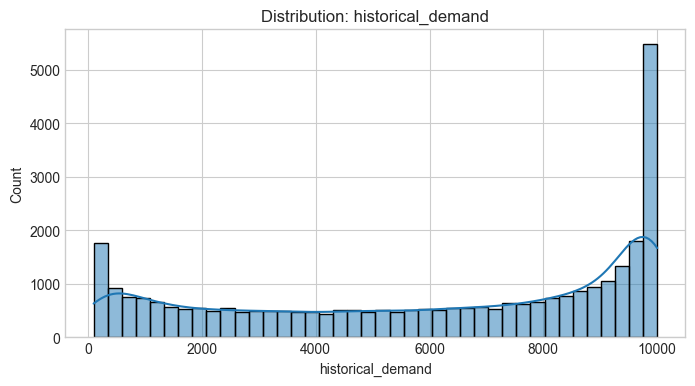

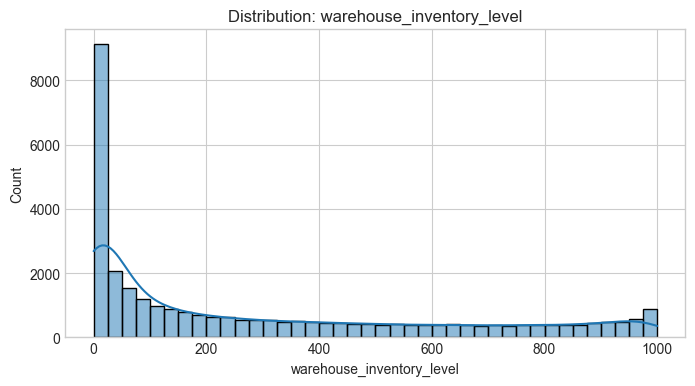

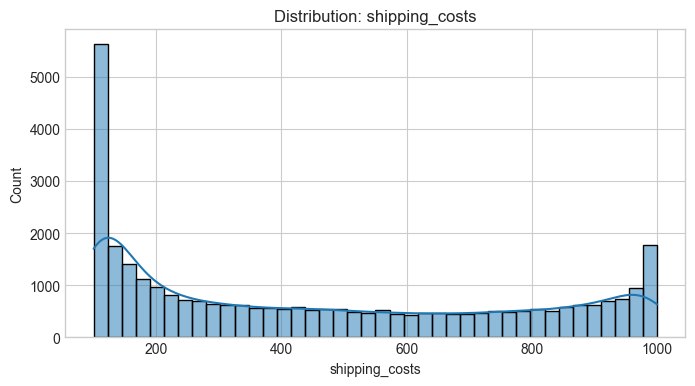

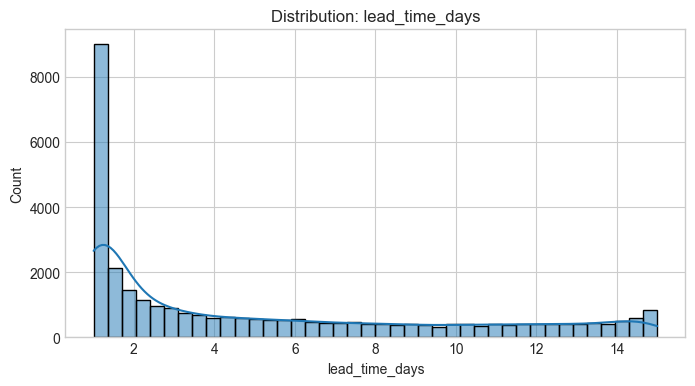

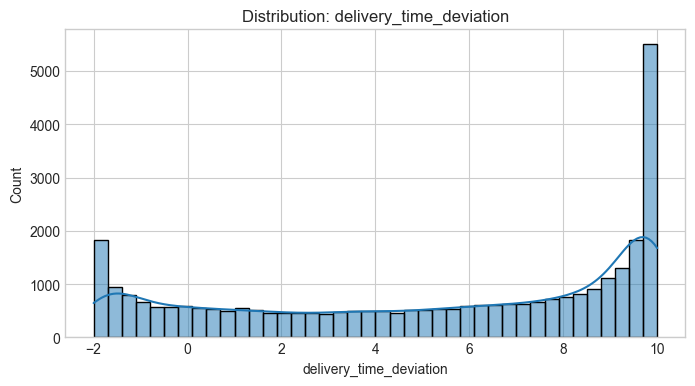

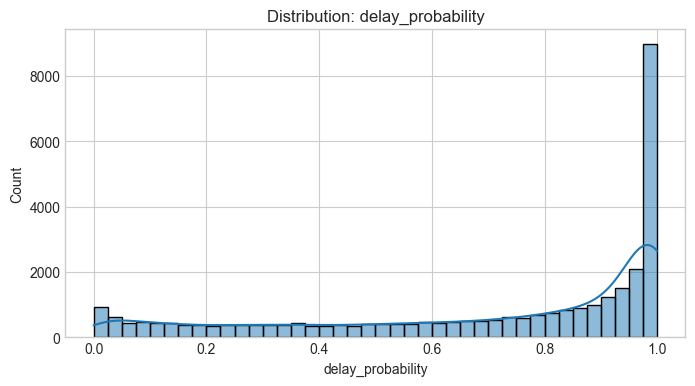

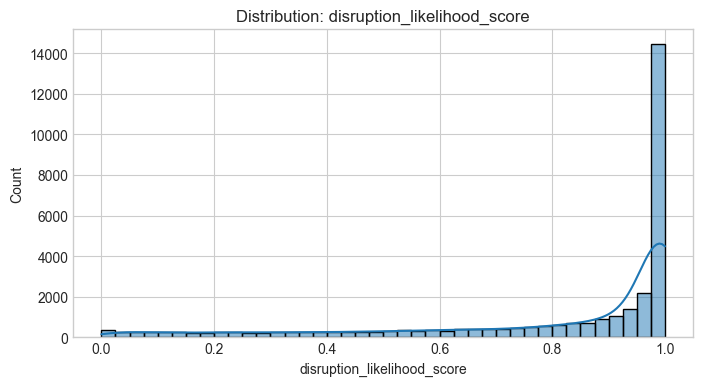

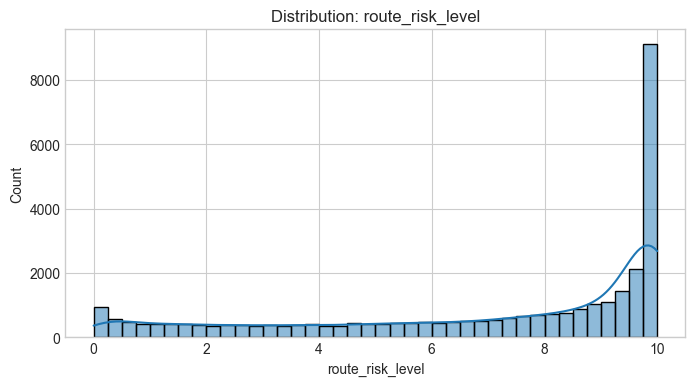

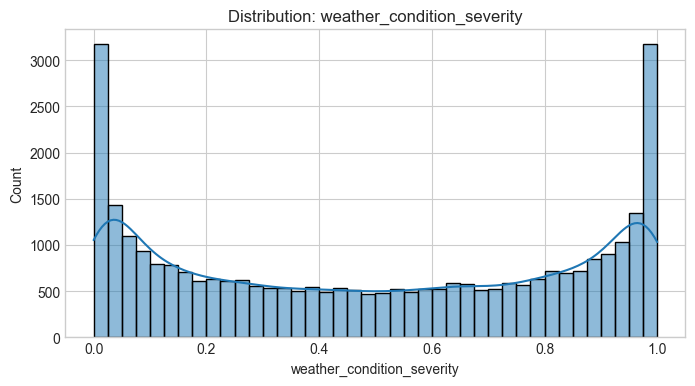

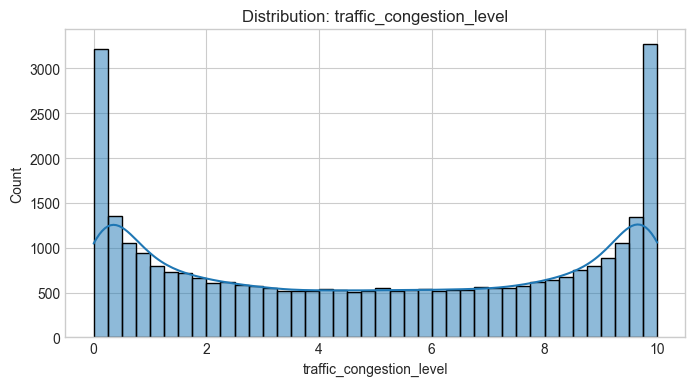

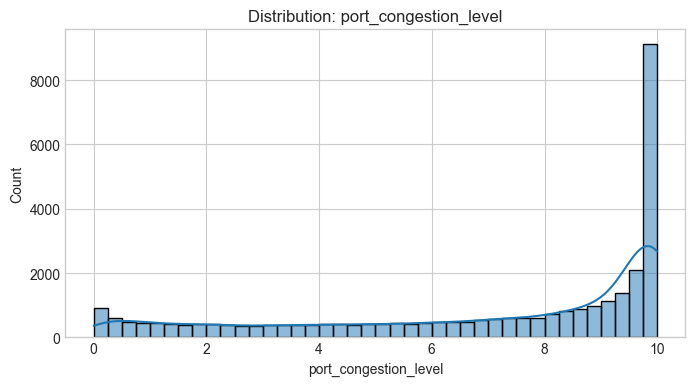

In [23]:
key_vars = [
    "historical_demand",
    "warehouse_inventory_level",
    "shipping_costs",
    "lead_time_days",
    "delivery_time_deviation",
    "delay_probability",
    "disruption_likelihood_score",
    "route_risk_level",
    "weather_condition_severity",
    "traffic_congestion_level",
    "port_congestion_level"
]

for col in key_vars:
    if col in supply_df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(supply_df[col].dropna(), bins=40, kde=True)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


### Outlier scan using IQR

In [24]:
def iqr_outlier_summary(dataframe, cols):
    rows = []
    for col in cols:
        x = dataframe[col].dropna()
        if len(x) == 0:
            continue
        q1, q3 = x.quantile(0.25), x.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        out = ((x < lo) | (x > hi)).mean() * 100
        rows.append([col, float(q1), float(q3), float(lo), float(hi), round(out, 2)])
    return pd.DataFrame(rows, columns=["col","q1","q3","lo","hi","outlier_%"]).sort_values("outlier_%", ascending=False)

iqr_outlier_summary(supply_df, [c for c in key_vars if c in supply_df.columns]).head(15)


,col,q1,q3,lo,hi,outlier_%
6,disruption_likelihood_score,0.693739,0.998746,0.236229,1.456255,7.78
0,historical_demand,2822.607616,9374.252913,-7004.860330,19201.720858,0.00
1,warehouse_inventory_level,16.051635,540.597991,-770.767899,1327.417525,0.00
2,shipping_costs,154.017124,753.007203,-744.467996,1651.492322,0.00
3,lead_time_days,1.237490,8.625720,-9.844856,19.708066,0.00
4,delivery_time_deviation,1.269197,9.249206,-10.700816,21.219219,0.00
5,delay_probability,0.456009,0.982391,-0.333564,1.771964,0.00
7,route_risk_level,4.593407,9.836152,-3.270710,17.700269,0.00
8,weather_condition_severity,0.144014,0.849823,-0.914700,1.908536,0.00
9,traffic_congestion_level,1.474720,8.534902,-9.115552,19.125174,0.00


**Interpretation**
Outliers in costs, delays, or demand can be real disruption events.
Instead of removing them blindly, we typically:
- cap/winsorize for modeling, and/or
- keep and treat them as disruption cases for risk analysis.


### Correlation heatmap

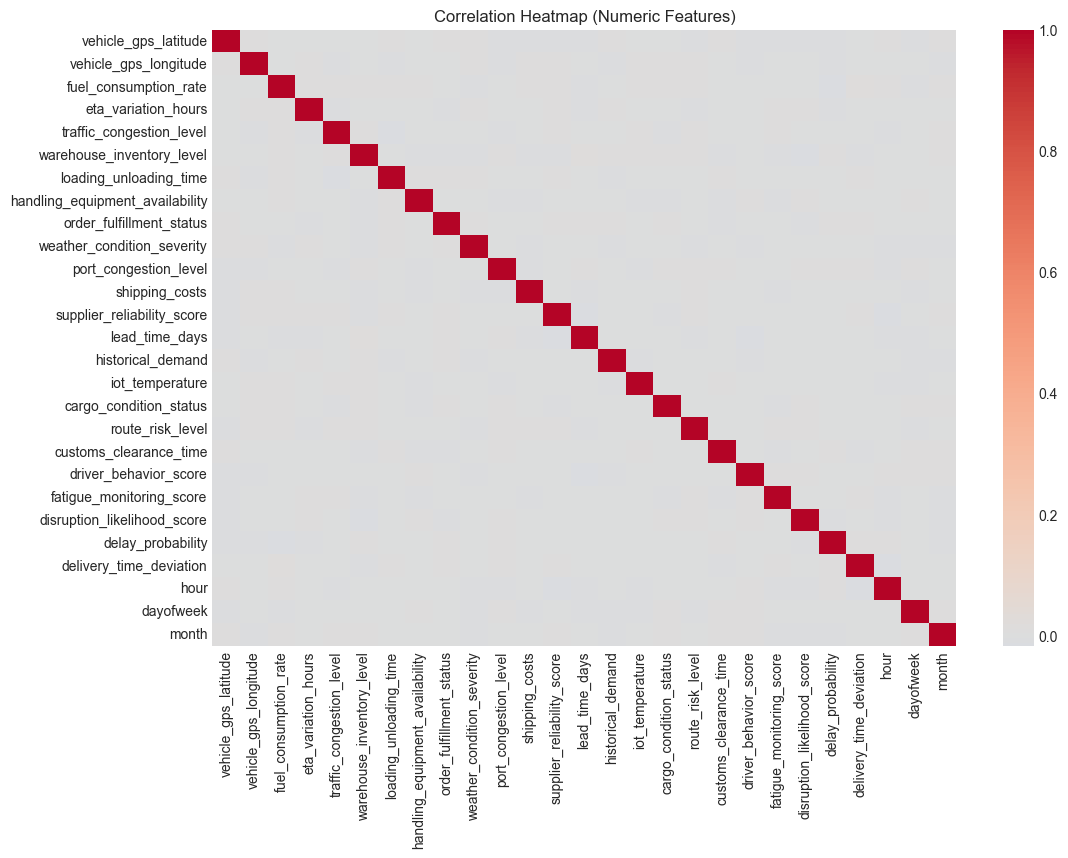

In [25]:
plt.figure(figsize=(12,8))
corr = supply_df[num_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


### Inventory vs demand relationship

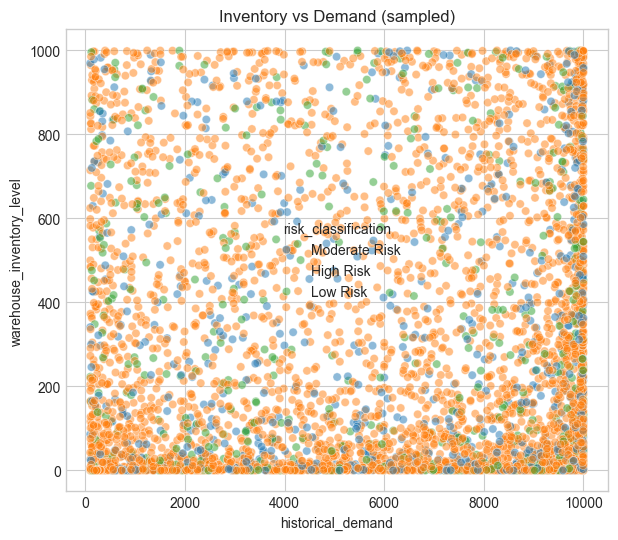

In [26]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=supply_df.sample(min(5000, len(supply_df)), random_state=42),
    x="historical_demand",
    y="warehouse_inventory_level",
    hue="risk_classification" if "risk_classification" in supply_df.columns else None,
    alpha=0.5
)
plt.title("Inventory vs Demand (sampled)")
plt.xlabel("historical_demand")
plt.ylabel("warehouse_inventory_level")
plt.show()


### Construct an “imbalance” feature (surplus/shortage proxy)

In [27]:
supply_df["inventory_gap"] = supply_df["warehouse_inventory_level"] - supply_df["historical_demand"]

supply_df["inventory_status"] = np.where(
    supply_df["inventory_gap"] > 0, "Surplus",
    np.where(supply_df["inventory_gap"] < 0, "Shortage", "Balanced")
)

supply_df["inventory_status"].value_counts()


inventory_status
Shortage    30804
Surplus      1261
Name: count, dtype: int64

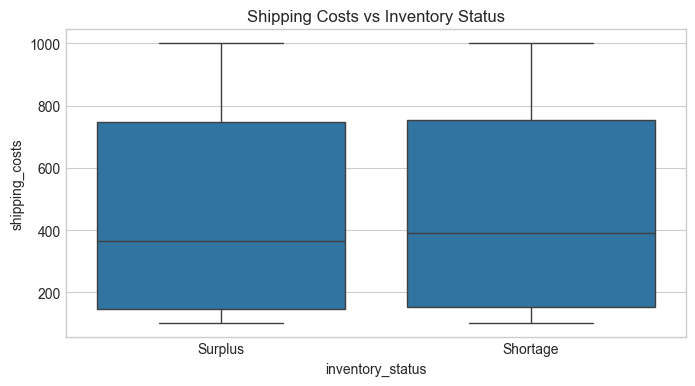

In [28]:
plt.figure(figsize=(8,4))
sns.boxplot(data=supply_df, x="inventory_status", y="shipping_costs")
plt.title("Shipping Costs vs Inventory Status")
plt.show()


### Risk vs delay/service analysis

In [29]:
metrics = [
    "warehouse_inventory_level",
    "lead_time_days",
    "shipping_costs",
    "delay_probability",
    "delivery_time_deviation"
]

print(supply_df[metrics].describe())
print(supply_df["risk_classification"].value_counts())

       warehouse_inventory_level  lead_time_days  shipping_costs  \
count               3.206500e+04    32065.000000    32065.000000   
mean                2.992547e+02        5.227502      459.374452   
std                 3.234435e+02        4.523085      312.183487   
min                 1.322210e-12        1.000000      100.000000   
25%                 1.605163e+01        1.237490      154.017124   
50%                 1.572880e+02        3.297654      388.996911   
75%                 5.405980e+02        8.625720      753.007203   
max                 9.999993e+02       14.999995      999.999853   

       delay_probability  delivery_time_deviation  
count       32065.000000             32065.000000  
mean            0.699077                 5.177648  
std             0.324514                 4.157988  
min             0.000003                -1.999998  
25%             0.456009                 1.269197  
50%             0.839599                 6.113662  
75%             0.98239

**Insight:**
High-risk scenarios dominate the logistics data, making it suitable for
stress-testing allocation decisions.

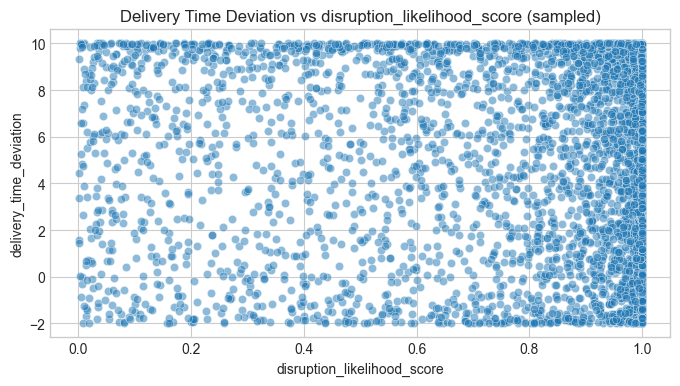

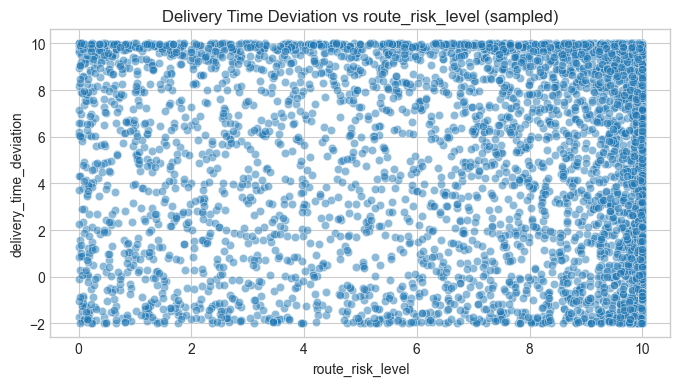

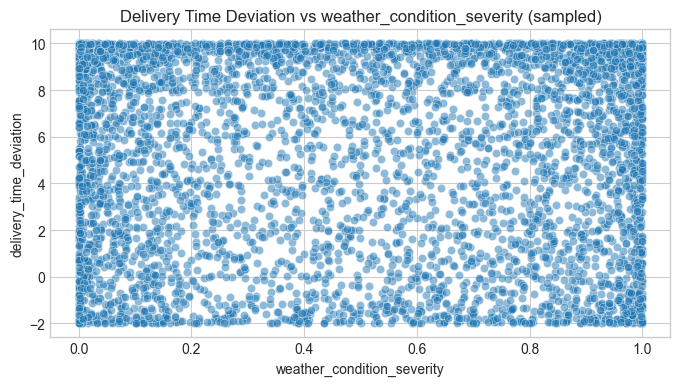

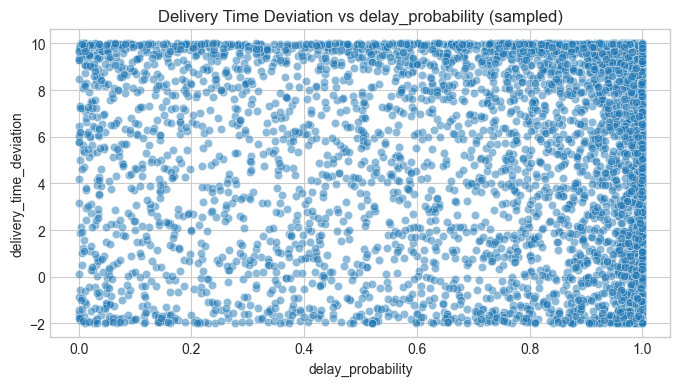

In [30]:
risk_vars = ["disruption_likelihood_score", "route_risk_level", "weather_condition_severity", "delay_probability"]

for rv in risk_vars:
    if rv in supply_df.columns:
        plt.figure(figsize=(8,4))
        sns.scatterplot(
            data=supply_df.sample(min(5000, len(supply_df)), random_state=42),
            x=rv,
            y="delivery_time_deviation",
            alpha=0.5
        )
        plt.title(f"Delivery Time Deviation vs {rv} (sampled)")
        plt.xlabel(rv)
        plt.ylabel("delivery_time_deviation")
        plt.show()


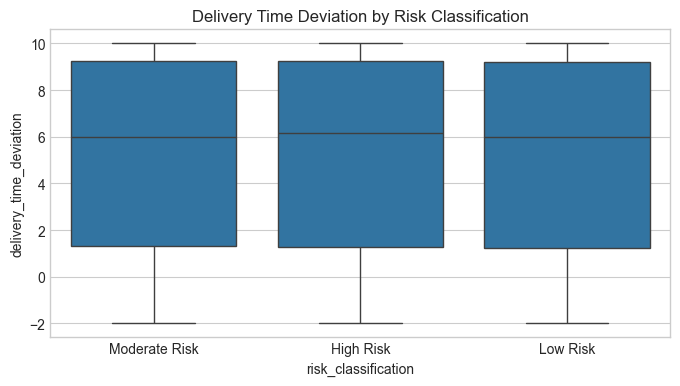

In [31]:
plt.figure(figsize=(8,4))
sns.boxplot(data=supply_df, x="risk_classification", y="delivery_time_deviation")
plt.title("Delivery Time Deviation by Risk Classification")
plt.show()


### Time-based trends (demand, inventory, risk)

In [32]:
daily = supply_df.groupby("date").agg(
    demand=("historical_demand","sum"),
    inventory=("warehouse_inventory_level","sum"),
    avg_delay=("delivery_time_deviation","mean"),
    avg_risk=("disruption_likelihood_score","mean"),
    avg_shipping_cost=("shipping_costs","mean")
).reset_index()

daily["date"] = pd.to_datetime(daily["date"])

daily.head()


,date,demand,inventory,avg_delay,avg_risk,avg_shipping_cost
0,2021-01-01,146105.722646,7237.843269,5.629205,0.855860,400.038948
1,2021-01-02,180336.393089,8914.122309,5.897185,0.919868,565.635388
2,2021-01-03,151003.300428,6142.809277,5.165200,0.852160,487.533988
3,2021-01-04,128532.827740,8205.377923,5.478182,0.730925,343.179154
4,2021-01-05,155817.199511,6919.012092,4.698579,0.788526,382.974045


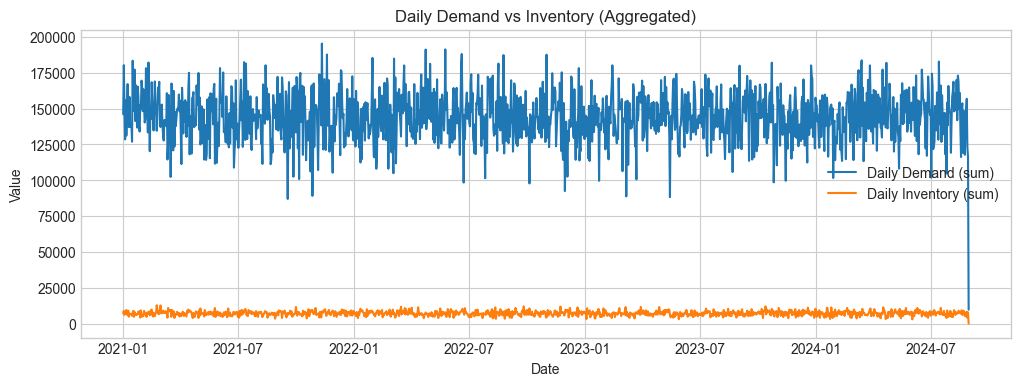

In [33]:
plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["demand"], label="Daily Demand (sum)")
plt.plot(daily["date"], daily["inventory"], label="Daily Inventory (sum)")
plt.title("Daily Demand vs Inventory (Aggregated)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


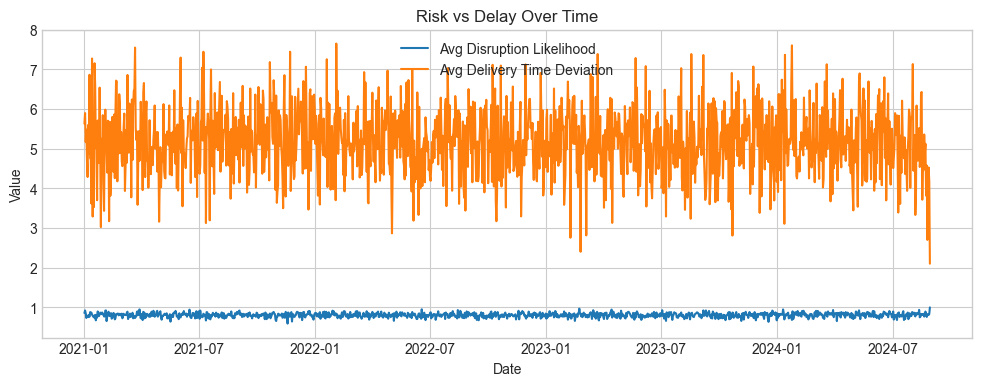

In [34]:
plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["avg_risk"], label="Avg Disruption Likelihood")
plt.plot(daily["date"], daily["avg_delay"], label="Avg Delivery Time Deviation")
plt.title("Risk vs Delay Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
eda_df = supply_df.copy()

# Optional: cap extreme outliers for modeling (NOT deleting)
for c in ["shipping_costs", "delivery_time_deviation", "historical_demand"]:
    q1 = eda_df[c].quantile(0.01)
    q99 = eda_df[c].quantile(0.99)
    eda_df[c] = eda_df[c].clip(q1, q99)

eda_df.to_csv("output/eda_cleaned_logistics_data.csv", index=False)


## EDA Summary

This section summarizes the key findings from the exploratory analysis, organized by dataset, and explains how these findings informed subsequent modeling decisions.

---

### Retail Demand Dataset 

- The retail dataset contains daily demand records across a large number of stores and products, providing sufficient scale and diversity for analysis.
- Demand is recorded at a daily level with no duplicate store–product–date combinations, making it directly suitable for time-series forecasting without further temporal aggregation.
- Daily sales values are generally low and right-skewed, with many instances of zero sales and occasional higher-demand days.
- Stockouts are frequent, occurring in nearly half of the records, indicating that observed sales may understate true demand.
- Demand varies significantly across both stores and products, with a small number of stores and products accounting for a large share of total sales.
- Holiday and activity indicators show a meaningful association with demand, while discount presence does not consistently increase observed sales.
- Based on these observations, demand forecasting will be performed at the daily level, treating stores as plants and focusing on a subset of high-volume products for clarity and efficiency.

---

### Logistics and Supply Chain Dataset

- The logistics dataset contains transportation cost, lead time, and multiple risk-related variables derived from operational events.
- Cost, delay probability, and route risk variables are available in numeric form and exhibit realistic variation.
- The dataset does not provide explicit source–destination plant pairs, indicating that it is best suited for parameter estimation rather than direct merging with retail demand data.
- These variables will be aggregated and used to simulate transportation cost and risk parameters in the optimization model.

---

### Overall EDA Takeaways

- The retail and logistics datasets serve complementary roles and are not intended to be merged at a transactional level.
- Demand patterns exhibit sparsity, variability, and stockout effects that must be explicitly considered in modeling.
- The EDA supports the use of a data-driven allocation framework that combines demand forecasting with cost- and risk-aware optimization.
- All preprocessing and modeling steps that follow are grounded in the empirical patterns observed during EDA.


In [36]:
demand_df.head()

,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.1,[0. 0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0...,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.1,[0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0. 0...,1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1],1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.1,[0. 0. 0. 0. 0. 0. 0. 0. 0.1 0. 0. 0...,11,[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1],1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.2,[0. 0. 0. 0. 0. 0. 0.1 0. 0. 0. 0. 0...,8,[1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1],1.0,0,0,3.5386,15.37,78.26,1.25


In [37]:
supply_df.head()

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation,date,hour,dayofweek,month,inventory_gap,inventory_status
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682,2021-01-01,0,4,1,884.944008,Surplus
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281,2021-01-01,1,4,1,-4917.037909,Shortage
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594,2021-01-01,2,4,1,-762.640211,Shortage
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,0.742735,3.818972,2530.431941,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897,2021-01-01,3,4,1,-2529.858657,Shortage
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,0.431088,14.001491,2146.190197,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484,2021-01-01,4,4,1,-1231.265130,Shortage


## 6. Data Cleaning & Transformation


In [38]:
# Parse dates
demand_df['date'] = pd.to_datetime(demand_df['dt'])
supply_df['timestamp'] = pd.to_datetime(supply_df['timestamp'])
supply_df['date'] = supply_df['timestamp'].dt.date

print("Dates parsed successfully!")

# Check for missing values
print("\nMissing values in demand data:")
missing_demand = demand_df.isnull().sum()
print(missing_demand[missing_demand > 0] if missing_demand.sum() > 0 else "None")

print("\nMissing values in supply data:")
missing_supply = supply_df.isnull().sum()
print(missing_supply[missing_supply > 0] if missing_supply.sum() > 0 else "None")


Dates parsed successfully!

Missing values in demand data:
None

Missing values in supply data:
None


## 7. Create Plant-Level Aggregation

Each **store** is treated as a **plant** in the material allocation model.


We aggregate demand at the **store × product** level to enable:
1. **Product-level demand forecasting** - predict demand for each product at each store
2. **Product-level inventory optimization** - optimize inventory decisions per product per store

In [39]:
# Aggregate demand data to store × product level per day
store_product_daily = demand_df.groupby(['store_id', 'product_id', 'city_id', 'dt']).agg({
    'sale_amount': 'sum',                    # Total demand for this product at this store
    'stock_hour6_22_cnt': 'mean',            # Avg stock-out hours
    'discount': 'mean',                       # Avg discount applied
    'holiday_flag': 'max',                   # Was it a holiday?
    'activity_flag': 'max',                  # Any promotion?
}).reset_index()

store_product_daily.columns = ['store_id', 'product_id', 'city_id', 'date', 'demand', 
                                'avg_stockout_hours', 'avg_discount', 'is_holiday',
                                'has_promotion']

print(f"Store × Product daily data: {store_product_daily.shape[0]:,} rows")
print(f"Unique stores: {store_product_daily['store_id'].nunique()}")
print(f"Unique products: {store_product_daily['product_id'].nunique()}")
print(f"Unique store-product combinations: {store_product_daily.groupby(['store_id', 'product_id']).ngroups:,}")
display(store_product_daily.head(10))


Store × Product daily data: 4,500,000 rows
Unique stores: 898
Unique products: 865
Unique store-product combinations: 50,000


,store_id,product_id,city_id,date,demand,avg_stockout_hours,avg_discount,is_holiday,has_promotion
0,0,4,0,2024-03-28,0.5,13.0,0.882,0,1
1,0,4,0,2024-03-29,1.3,5.0,0.882,0,1
2,0,4,0,2024-03-30,5.3,0.0,0.882,1,1
3,0,4,0,2024-03-31,4.2,0.0,0.879,1,1
4,0,4,0,2024-04-01,0.7,0.0,0.882,0,1
5,0,4,0,2024-04-02,2.3,0.0,0.882,0,1
6,0,4,0,2024-04-03,1.3,5.0,0.877,0,1
7,0,4,0,2024-04-04,4.7,0.0,0.879,1,1
8,0,4,0,2024-04-05,3.1,1.0,0.876,1,1
9,0,4,0,2024-04-06,5.5,3.0,0.876,1,1


In [40]:
# Summary of store × product granularity
print(f"Date range: {store_product_daily['date'].min()} to {store_product_daily['date'].max()}")
print(f"Total days: {store_product_daily['date'].nunique()}")

Date range: 2024-03-28 00:00:00 to 2024-06-25 00:00:00
Total days: 90


## 8. Extract Transport Cost Parameters

Aggregating supply chain data to get average logistic parameters.

In [41]:
# Get overall transport/logistics parameters
transport_params = {
    'avg_shipping_cost': supply_df['shipping_costs'].mean(),
    'avg_lead_time_days': supply_df['lead_time_days'].mean(),
    'avg_delay_probability': supply_df['delay_probability'].mean(),
    'avg_delivery_deviation': supply_df['delivery_time_deviation'].mean(),
}

print("Transport Parameters:")
for k, v in transport_params.items():
    print(f"  {k}: {v:.2f}")


Transport Parameters:
  avg_shipping_cost: 459.37
  avg_lead_time_days: 5.23
  avg_delay_probability: 0.70
  avg_delivery_deviation: 5.18


## 9. Map Supply Chain Parameters to Cities (Spatial Clustering)

**Approach:** Use K-Means clustering to group the 32K supply chain observations into 18 geographic regions (matching our 18 cities). Then aggregate supply parameters per cluster and map cities to clusters.

**Benefits:**
- Uses actual supply chain values (shipping costs, lead times, delay probabilities, etc.)
- Maintains geographic grounding via GPS coordinates
- Creates city-level parameter profiles derived from real data


In [53]:
# =============================================================================
# Step 1: Cluster supply chain data into 18 geographic regions using K-Means
# =============================================================================

from sklearn.cluster import KMeans

# Get unique cities from demand data
cities = sorted(demand_df['city_id'].unique())
n_cities = len(cities)
print(f"Number of unique cities in demand data: {n_cities}")

# Extract GPS coordinates from supply chain data
gps_coords = supply_df[['vehicle_gps_latitude', 'vehicle_gps_longitude']].values

print(f"Supply chain records: {len(gps_coords):,}")
print(f"GPS coordinate ranges:")
print(f"  Latitude:  {gps_coords[:, 0].min():.2f} to {gps_coords[:, 0].max():.2f}")
print(f"  Longitude: {gps_coords[:, 1].min():.2f} to {gps_coords[:, 1].max():.2f}")

# Perform K-Means clustering to create 18 geographic clusters
kmeans = KMeans(n_clusters=n_cities, random_state=42, n_init=10)
supply_df['geo_cluster'] = kmeans.fit_predict(gps_coords)

# Get cluster centroids (these become our city coordinates)
cluster_centroids = kmeans.cluster_centers_
print(f"\nCreated {n_cities} geographic clusters")
print(f"Cluster sizes:")
display(supply_df['geo_cluster'].value_counts().sort_index())


Number of unique cities in demand data: 18
Supply chain records: 32,065
GPS coordinate ranges:
  Latitude:  30.00 to 50.00
  Longitude: -120.00 to -70.00

Created 18 geographic clusters
Cluster sizes:


geo_cluster
0     1445
1     1562
2     1069
3     2069
4     1470
5     2108
6     2637
7     1490
8     4386
9     1149
10    1824
11    2892
12    1248
13    1180
14    1194
15    1695
16    1031
17    1616
Name: count, dtype: int64

In [54]:
# =============================================================================
# Step 2: Aggregate supply chain parameters per cluster
# =============================================================================

# Define which columns to aggregate from supply chain data
supply_params_to_aggregate = {
    'shipping_costs': ['mean', 'std'],
    'lead_time_days': ['mean', 'std'],
    'delay_probability': ['mean', 'std'],
    'delivery_time_deviation': ['mean', 'std'],
    'route_risk_level': 'mean',
    'disruption_likelihood_score': 'mean',
    'supplier_reliability_score': 'mean',
    'traffic_congestion_level': 'mean',
    'weather_condition_severity': 'mean',
    'warehouse_inventory_level': 'mean',
}

# Aggregate parameters per cluster
cluster_params = supply_df.groupby('geo_cluster').agg(supply_params_to_aggregate).reset_index()

# Flatten column names
cluster_params.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                          for col in cluster_params.columns]

# Add cluster centroids
cluster_params['centroid_lat'] = cluster_centroids[:, 0]
cluster_params['centroid_lon'] = cluster_centroids[:, 1]

# Add record count per cluster
cluster_params['n_records'] = supply_df.groupby('geo_cluster').size().values

print("Cluster-level supply chain parameters:")
display(cluster_params)


Cluster-level supply chain parameters:


,geo_cluster,shipping_costs_mean,shipping_costs_std,lead_time_days_mean,lead_time_days_std,delay_probability_mean,delay_probability_std,delivery_time_deviation_mean,delivery_time_deviation_std,route_risk_level_mean,disruption_likelihood_score_mean,supplier_reliability_score_mean,traffic_congestion_level_mean,weather_condition_severity_mean,warehouse_inventory_level_mean,centroid_lat,centroid_lon,n_records
0,0,459.742201,312.476584,5.248957,4.502365,0.712918,0.314807,5.356446,4.166886,7.022159,0.799782,0.510963,4.965080,0.492202,292.372155,46.998330,-78.859072,1445
1,1,449.880981,308.033924,5.292902,4.550284,0.699243,0.325736,5.210983,4.195937,6.904765,0.798075,0.478710,4.976745,0.488365,299.113132,47.413393,-117.094488,1562
2,2,437.227507,309.809646,5.217698,4.464688,0.705930,0.318877,5.311567,4.100644,7.174808,0.795406,0.504638,5.041254,0.496453,291.661886,39.249949,-103.617543,1069
3,3,465.552869,312.354003,5.297173,4.583740,0.698327,0.322891,5.146613,4.153416,6.970915,0.803721,0.498137,4.943885,0.493051,289.469007,31.571807,-77.940028,2069
4,4,469.339456,309.569790,5.258421,4.550266,0.697125,0.324456,5.042464,4.159736,6.900759,0.797984,0.492121,5.105870,0.486996,302.599944,39.393792,-116.404987,1470
5,5,461.062874,316.065769,5.202010,4.502926,0.709998,0.318815,5.155758,4.198933,6.960431,0.808774,0.511795,5.103524,0.502315,301.278164,31.619411,-118.003004,2108
6,6,459.511482,310.969130,5.116855,4.443831,0.704972,0.319990,5.196400,4.155608,6.970679,0.805780,0.507852,4.994592,0.499257,295.628972,39.160467,-71.823994,2637
7,7,449.237727,310.841600,5.100252,4.486775,0.706613,0.318083,5.223901,4.138276,7.148644,0.811944,0.482070,4.993509,0.503722,287.514178,31.626295,-102.921142,1490
8,8,461.868026,313.820769,5.307122,4.546993,0.697936,0.324265,5.186624,4.188172,7.083620,0.800560,0.501841,4.966276,0.500836,293.789418,31.610671,-71.352636,4386
9,9,454.845991,308.531468,5.325994,4.618977,0.698387,0.328863,5.101740,4.206558,7.064941,0.797204,0.500564,4.991128,0.508445,292.409091,47.033762,-97.734137,1149


In [55]:
# =============================================================================
# Step 3: Map demand cities to supply clusters & create city parameters
# =============================================================================

# Map each demand city_id to a cluster (1-to-1 mapping since both have 18)
# Sort clusters by centroid longitude (west to east) for consistent mapping
cluster_order = np.argsort(cluster_centroids[:, 1])  # Sort by longitude

# Create city-to-cluster mapping
city_cluster_map = pd.DataFrame({
    'city_id': cities,
    'geo_cluster': cluster_order  # Assign cities to clusters in geographic order
})

# Merge to get city-level supply parameters
city_supply_params = city_cluster_map.merge(cluster_params, on='geo_cluster', how='left')

print("City-level supply chain parameters (from spatial clustering):")
display(city_supply_params)

# Summary statistics
print(f"\nCity parameter ranges:")
print(f"  Shipping costs:    ${city_supply_params['shipping_costs_mean'].min():.0f} - ${city_supply_params['shipping_costs_mean'].max():.0f}")
print(f"  Lead time (days):  {city_supply_params['lead_time_days_mean'].min():.1f} - {city_supply_params['lead_time_days_mean'].max():.1f}")
print(f"  Delay probability: {city_supply_params['delay_probability_mean'].min():.2f} - {city_supply_params['delay_probability_mean'].max():.2f}")


City-level supply chain parameters (from spatial clustering):


,city_id,geo_cluster,shipping_costs_mean,shipping_costs_std,lead_time_days_mean,lead_time_days_std,delay_probability_mean,delay_probability_std,delivery_time_deviation_mean,delivery_time_deviation_std,route_risk_level_mean,disruption_likelihood_score_mean,supplier_reliability_score_mean,traffic_congestion_level_mean,weather_condition_severity_mean,warehouse_inventory_level_mean,centroid_lat,centroid_lon,n_records
0,0,5,461.062874,316.065769,5.202010,4.502926,0.709998,0.318815,5.155758,4.198933,6.960431,0.808774,0.511795,5.103524,0.502315,301.278164,31.619411,-118.003004,2108
1,1,1,449.880981,308.033924,5.292902,4.550284,0.699243,0.325736,5.210983,4.195937,6.904765,0.798075,0.478710,4.976745,0.488365,299.113132,47.413393,-117.094488,1562
2,2,4,469.339456,309.569790,5.258421,4.550266,0.697125,0.324456,5.042464,4.159736,6.900759,0.797984,0.492121,5.105870,0.486996,302.599944,39.393792,-116.404987,1470
3,3,15,449.927345,307.297352,5.195671,4.549105,0.690385,0.330253,5.205759,4.109415,7.041896,0.812449,0.499146,4.979015,0.494022,309.283745,32.107983,-110.997119,1695
4,4,14,456.344369,308.236635,5.093510,4.451186,0.704229,0.323332,5.245021,4.116160,6.834601,0.787196,0.518715,5.109633,0.518940,293.644103,46.801294,-107.912096,1194
5,5,2,437.227507,309.809646,5.217698,4.464688,0.705930,0.318877,5.311567,4.100644,7.174808,0.795406,0.504638,5.041254,0.496453,291.661886,39.249949,-103.617543,1069
6,6,7,449.237727,310.841600,5.100252,4.486775,0.706613,0.318083,5.223901,4.138276,7.148644,0.811944,0.482070,4.993509,0.503722,287.514178,31.626295,-102.921142,1490
7,7,9,454.845991,308.531468,5.325994,4.618977,0.698387,0.328863,5.101740,4.206558,7.064941,0.797204,0.500564,4.991128,0.508445,292.409091,47.033762,-97.734137,1149
8,8,17,468.016731,319.362405,5.180931,4.496923,0.697986,0.327805,5.333913,4.105510,7.071340,0.799999,0.515597,4.996737,0.493806,310.889108,32.048079,-94.844658,1616
9,9,16,447.950544,314.658566,5.190689,4.469950,0.693968,0.329062,5.041248,4.085643,6.961440,0.823309,0.492287,5.121260,0.482141,315.600347,39.632279,-91.452632,1031



City parameter ranges:
  Shipping costs:    $437 - $474
  Lead time (days):  5.1 - 5.4
  Delay probability: 0.69 - 0.71


In [56]:
# =============================================================================
# Step 4: Build city-to-city transport cost matrix using Haversine distances
# =============================================================================

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points on Earth (km)."""
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

# Build city-to-city distance matrix using cluster centroids
city_distance_matrix = np.zeros((n_cities, n_cities))
city_lats = city_supply_params['centroid_lat'].values
city_lons = city_supply_params['centroid_lon'].values

for i in range(n_cities):
    for j in range(n_cities):
        if i != j:
            city_distance_matrix[i, j] = haversine_distance(
                city_lats[i], city_lons[i], city_lats[j], city_lons[j]
            )

# Transport cost model: use cluster-specific shipping costs + distance factor
# Cost(i→j) = base_cost_i * distance_factor(i,j)
# where distance_factor scales with relative distance

avg_distance = city_distance_matrix[city_distance_matrix > 0].mean()
max_distance = city_distance_matrix.max()

# Create cost matrix: origin's shipping cost scaled by normalized distance
city_cost_matrix = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    base_cost_i = city_supply_params.loc[i, 'shipping_costs_mean']
    for j in range(n_cities):
        if i == j:
            city_cost_matrix[i, j] = 0
        else:
            # Scale cost by relative distance (closer = cheaper)
            distance_factor = 0.5 + 0.5 * (city_distance_matrix[i, j] / max_distance)
            city_cost_matrix[i, j] = base_cost_i * distance_factor

# Make symmetric (average of both directions)
city_cost_matrix = (city_cost_matrix + city_cost_matrix.T) / 2

print(f"City-to-City Distance Matrix (km):")
print(f"  Min: {city_distance_matrix[city_distance_matrix > 0].min():.0f} km")
print(f"  Max: {max_distance:.0f} km")
print(f"  Mean: {avg_distance:.0f} km")

print(f"\nCity-to-City Transport Costs ($):")
print(f"  Min: ${city_cost_matrix[city_cost_matrix > 0].min():.0f}")
print(f"  Max: ${city_cost_matrix.max():.0f}")
print(f"  Mean: ${city_cost_matrix[city_cost_matrix > 0].mean():.0f}")


City-to-City Distance Matrix (km):
  Min: 558 km
  Max: 4382 km
  Mean: 2033 km

City-to-City Transport Costs ($):
  Min: $258
  Max: $461
  Mean: $336


In [57]:
# =============================================================================
# Step 5: Create store-to-store cost matrix and store-level supply parameters
# =============================================================================

# Get store-to-city mapping
store_city_map = demand_df.groupby('store_id')['city_id'].first().reset_index()
store_city_map.columns = ['store_id', 'city_id']

# Merge store with city-level supply parameters
store_supply_params = store_city_map.merge(city_supply_params, on='city_id', how='left')

print(f"Store-to-city mapping: {len(store_city_map)} stores across {store_city_map['city_id'].nunique()} cities")

# Create store-to-store cost matrix based on city costs
stores = sorted(store_city_map['store_id'].unique())
n_stores = len(stores)

# Create city index lookup
city_to_idx = {c: i for i, c in enumerate(cities)}

# Build store-to-store cost matrix
local_delivery_cost = 20  # $ for same-city transfers

print(f"\nBuilding {n_stores}x{n_stores} store-to-store cost matrix...")
store_cost_matrix = np.zeros((n_stores, n_stores))

# Vectorized approach using store-city mapping
store_cities = store_city_map.set_index('store_id')['city_id'].to_dict()

for i, store_i in enumerate(stores):
    city_i_idx = city_to_idx[store_cities[store_i]]
    for j, store_j in enumerate(stores):
        if i == j:
            continue
        city_j_idx = city_to_idx[store_cities[store_j]]
        if city_i_idx == city_j_idx:
            store_cost_matrix[i, j] = local_delivery_cost
        else:
            store_cost_matrix[i, j] = city_cost_matrix[city_i_idx, city_j_idx]

print(f"Store-to-Store Transport Cost Matrix: {n_stores}x{n_stores}")
print(f"  Local (same-city) cost: ${local_delivery_cost}")
print(f"  Min inter-city cost: ${store_cost_matrix[store_cost_matrix > local_delivery_cost].min():.0f}")
print(f"  Max inter-city cost: ${store_cost_matrix.max():.0f}")
print(f"  Mean cost: ${store_cost_matrix[store_cost_matrix > 0].mean():.0f}")


Store-to-city mapping: 898 stores across 18 cities

Building 898x898 store-to-store cost matrix...
Store-to-Store Transport Cost Matrix: 898x898
  Local (same-city) cost: $20
  Min inter-city cost: $258
  Max inter-city cost: $461
  Mean cost: $302


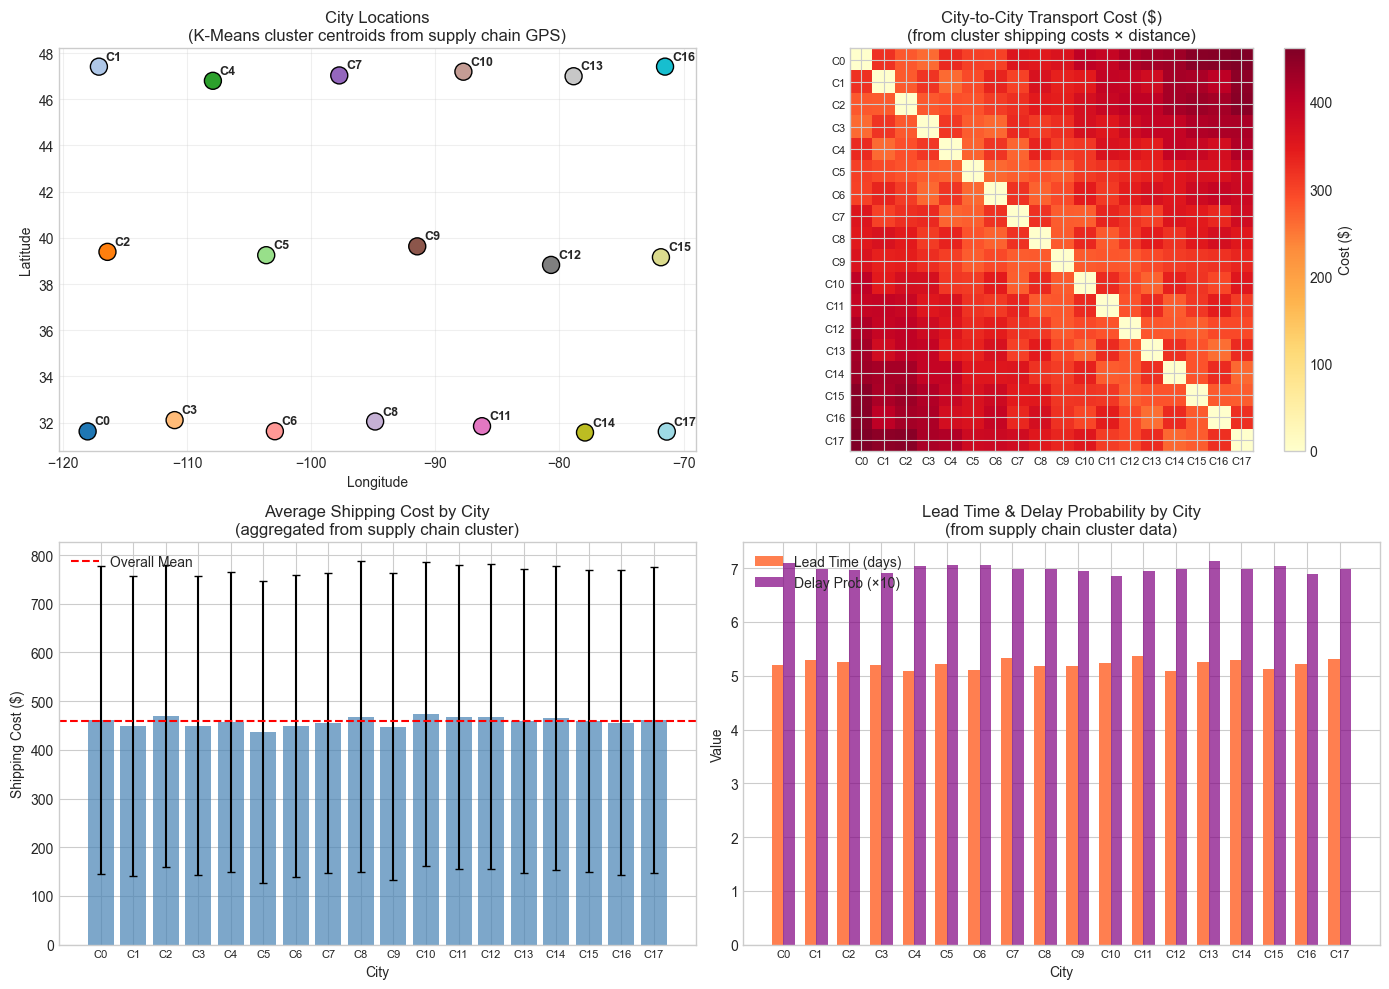

In [58]:
# =============================================================================
# Step 6: Visualize the spatial clustering and supply parameters
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cluster centroids (city locations)
ax1 = axes[0, 0]
scatter = ax1.scatter(city_supply_params['centroid_lon'], city_supply_params['centroid_lat'], 
                       c=city_supply_params['city_id'], cmap='tab20', s=150, edgecolors='black')
for idx, row in city_supply_params.iterrows():
    ax1.annotate(f"C{int(row['city_id'])}", (row['centroid_lon'], row['centroid_lat']), 
                 textcoords="offset points", xytext=(5,5), fontsize=9, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('City Locations\n(K-Means cluster centroids from supply chain GPS)')
ax1.grid(True, alpha=0.3)

# Plot 2: City-to-city cost heatmap
ax2 = axes[0, 1]
im = ax2.imshow(city_cost_matrix, cmap='YlOrRd')
ax2.set_xticks(range(n_cities))
ax2.set_yticks(range(n_cities))
ax2.set_xticklabels([f"C{c}" for c in cities], fontsize=8)
ax2.set_yticklabels([f"C{c}" for c in cities], fontsize=8)
ax2.set_title('City-to-City Transport Cost ($)\n(from cluster shipping costs × distance)')
plt.colorbar(im, ax=ax2, label='Cost ($)')

# Plot 3: Shipping costs by city
ax3 = axes[1, 0]
ax3.bar(range(n_cities), city_supply_params['shipping_costs_mean'], 
        yerr=city_supply_params['shipping_costs_std'], capsize=3, color='steelblue', alpha=0.7)
ax3.set_xticks(range(n_cities))
ax3.set_xticklabels([f"C{c}" for c in cities], fontsize=8)
ax3.set_xlabel('City')
ax3.set_ylabel('Shipping Cost ($)')
ax3.set_title('Average Shipping Cost by City\n(aggregated from supply chain cluster)')
ax3.axhline(y=city_supply_params['shipping_costs_mean'].mean(), color='red', linestyle='--', label='Overall Mean')
ax3.legend()

# Plot 4: Lead time and delay probability by city
ax4 = axes[1, 1]
x = np.arange(n_cities)
width = 0.35
ax4.bar(x - width/2, city_supply_params['lead_time_days_mean'], width, label='Lead Time (days)', color='coral')
ax4.bar(x + width/2, city_supply_params['delay_probability_mean'] * 10, width, label='Delay Prob (×10)', color='purple', alpha=0.7)
ax4.set_xticks(x)
ax4.set_xticklabels([f"C{c}" for c in cities], fontsize=8)
ax4.set_xlabel('City')
ax4.set_ylabel('Value')
ax4.set_title('Lead Time & Delay Probability by City\n(from supply chain cluster data)')
ax4.legend()

plt.tight_layout()
plt.show()


### Spatial Clustering Summary

**Methodology:**
1. K-Means clustering on supply chain GPS coordinates → 18 geographic clusters
2. Aggregate supply chain parameters (shipping costs, lead times, delays) per cluster
3. Map demand cities to clusters based on geographic ordering
4. Derive transport costs from cluster shipping costs × Haversine distance

**Key Parameters Extracted (per city):**
- `shipping_costs_mean/std` - Average and variability of shipping costs
- `lead_time_days_mean/std` - Average and variability of lead times
- `delay_probability_mean` - Probability of delivery delay
- `route_risk_level` - Transportation route risk
- `supplier_reliability_score` - Supplier reliability metric
- `disruption_likelihood_score` - Risk of supply disruption


## 10. Visualize Inventory Imbalances


In [43]:
# Calculate inventory parameters per store × product combination
store_product_params = store_product_daily.groupby(['store_id', 'product_id', 'city_id']).agg({
    'demand': ['mean', 'std', 'sum', 'count'],
    'avg_stockout_hours': 'mean',
    'avg_discount': 'mean',
    'is_holiday': 'mean',  # Proportion of holiday days
    'has_promotion': 'mean'  # Proportion of promotion days
}).reset_index()

# Flatten column names
store_product_params.columns = ['store_id', 'product_id', 'city_id', 
                                 'avg_daily_demand', 'demand_std', 'total_demand', 'num_days',
                                 'avg_stockout_hours', 'avg_discount', 
                                 'holiday_proportion', 'promotion_proportion']

# Calculate coefficient of variation (CV) for demand variability
store_product_params['demand_cv'] = (
    store_product_params['demand_std'] / store_product_params['avg_daily_demand']
).replace([np.inf, -np.inf], np.nan).fillna(0)

# Simulate current inventory levels (for demonstration)
np.random.seed(42)
store_product_params['current_inventory'] = (
    store_product_params['avg_daily_demand'] * 7  # ~1 week of inventory
    * (1 + np.random.randn(len(store_product_params)) * 0.3)
).clip(lower=0)

# Calculate inventory imbalance
store_product_params['inventory_imbalance'] = (
    store_product_params['current_inventory'] - store_product_params['avg_daily_demand'] * 7
)

print(f"Store × Product parameters: {store_product_params.shape[0]:,} rows")
print(f"\nParameter summary:")
display(store_product_params.describe())
display(store_product_params.head(10))


Store × Product parameters: 50,000 rows

Parameter summary:


,store_id,product_id,city_id,avg_daily_demand,demand_std,total_demand,num_days,avg_stockout_hours,avg_discount,holiday_proportion,promotion_proportion,demand_cv,current_inventory,inventory_imbalance
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,409.080660,390.425980,4.97442,0.998591,0.530334,89.873216,90.0,3.180341,0.911141,3.444444e-01,0.378421,0.566490,6.983193,-0.006946
std,248.548105,263.472299,6.09666,1.152598,0.613609,103.733832,0.0,1.314233,0.099421,1.110234e-16,0.325058,0.209332,8.547706,3.186068
min,0.000000,0.000000,0.00000,0.222000,0.101760,19.980000,90.0,0.622222,0.000000,3.444444e-01,0.000000,0.164274,0.000000,-88.536053
25%,195.000000,135.000000,0.00000,0.494222,0.270176,44.480000,90.0,2.377778,0.869978,3.444444e-01,0.075000,0.430846,3.317543,-1.008708
50%,395.000000,363.000000,0.00000,0.657778,0.368446,59.200000,90.0,2.827778,0.939981,3.444444e-01,0.311111,0.514077,4.676237,0.002452
75%,598.000000,633.000000,12.00000,1.054444,0.582901,94.900000,90.0,3.511111,0.980333,3.444444e-01,0.655556,0.641412,7.506063,1.010410
max,897.000000,864.000000,17.00000,19.074444,12.210885,1716.700000,90.0,15.522222,1.000000,3.444444e-01,1.000000,3.007781,197.397976,81.617976


,store_id,product_id,city_id,avg_daily_demand,demand_std,total_demand,num_days,avg_stockout_hours,avg_discount,holiday_proportion,promotion_proportion,demand_cv,current_inventory,inventory_imbalance
0,0,4,0,2.701111,2.556309,243.10,90,2.500000,0.869726,0.344444,0.422222,0.946392,21.725306,2.817528
1,0,6,0,0.838889,0.469687,75.50,90,4.011111,0.754011,0.344444,0.766667,0.559891,5.628647,-0.243576
2,0,18,0,0.413111,0.317521,37.18,90,3.944444,0.999178,0.344444,0.000000,0.768609,3.453669,0.561891
3,0,19,0,1.076667,0.522322,96.90,90,4.633333,0.999078,0.344444,0.000000,0.485129,10.980237,3.443571
4,0,21,0,0.707778,0.367875,63.70,90,4.500000,0.986756,0.344444,0.155556,0.519761,4.606414,-0.348030
5,0,23,0,0.642444,0.451540,57.82,90,3.400000,0.955022,0.344444,0.133333,0.702847,4.181229,-0.315882
6,0,26,0,0.764667,0.305431,68.82,90,3.611111,0.912222,0.344444,0.911111,0.399430,7.888567,2.535900
7,0,38,0,0.436667,0.834030,39.30,90,2.600000,0.907239,0.344444,0.477778,1.909993,3.760404,0.703738
8,0,41,0,0.803111,0.693027,72.28,90,7.533333,0.877267,0.344444,0.588889,0.862928,4.829994,-0.791784
9,0,70,0,4.263333,1.685060,383.70,90,2.800000,1.000000,0.344444,0.088889,0.395245,34.700873,4.857540


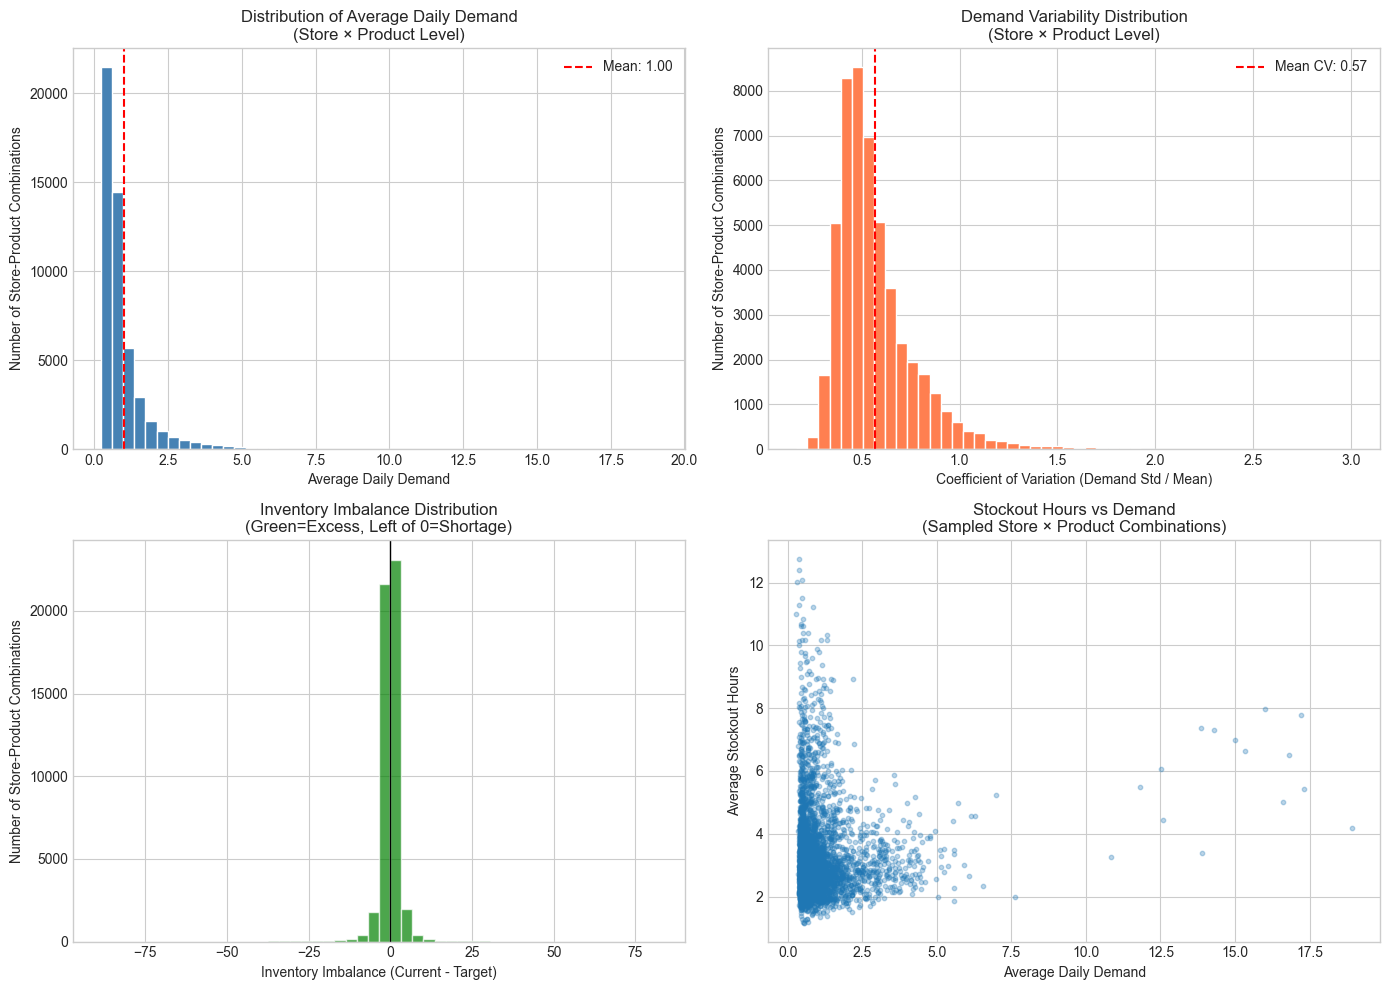


STORE × PRODUCT PARAMETER SUMMARY
Total store-product combinations: 50,000
Combinations with surplus inventory: 25,032
Combinations with shortage: 24,968
Average demand CV: 0.57
Products with high variability (CV > 1): 1,970


In [44]:
# Visualize store × product level distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribution of average daily demand per store-product
axes[0, 0].hist(store_product_params['avg_daily_demand'], bins=50, color='steelblue', edgecolor='white')
axes[0, 0].set_xlabel('Average Daily Demand')
axes[0, 0].set_ylabel('Number of Store-Product Combinations')
axes[0, 0].set_title('Distribution of Average Daily Demand\n(Store × Product Level)')
axes[0, 0].axvline(store_product_params['avg_daily_demand'].mean(), color='red', linestyle='--', label=f"Mean: {store_product_params['avg_daily_demand'].mean():.2f}")
axes[0, 0].legend()

# Plot 2: Demand coefficient of variation
cv_valid = store_product_params[store_product_params['demand_cv'] < 10]['demand_cv']  # Filter extreme CVs
axes[0, 1].hist(cv_valid, bins=50, color='coral', edgecolor='white')
axes[0, 1].set_xlabel('Coefficient of Variation (Demand Std / Mean)')
axes[0, 1].set_ylabel('Number of Store-Product Combinations')
axes[0, 1].set_title('Demand Variability Distribution\n(Store × Product Level)')
axes[0, 1].axvline(cv_valid.mean(), color='red', linestyle='--', label=f"Mean CV: {cv_valid.mean():.2f}")
axes[0, 1].legend()

# Plot 3: Inventory imbalance distribution
axes[1, 0].hist(store_product_params['inventory_imbalance'], bins=50, color='green', edgecolor='white', alpha=0.7)
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Inventory Imbalance (Current - Target)')
axes[1, 0].set_ylabel('Number of Store-Product Combinations')
axes[1, 0].set_title('Inventory Imbalance Distribution\n(Green=Excess, Left of 0=Shortage)')

# Plot 4: Stockout hours vs demand
sample = store_product_params.sample(min(5000, len(store_product_params)), random_state=42)
axes[1, 1].scatter(sample['avg_daily_demand'], sample['avg_stockout_hours'], alpha=0.3, s=10)
axes[1, 1].set_xlabel('Average Daily Demand')
axes[1, 1].set_ylabel('Average Stockout Hours')
axes[1, 1].set_title('Stockout Hours vs Demand\n(Sampled Store × Product Combinations)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("STORE × PRODUCT PARAMETER SUMMARY")
print("="*60)
print(f"Total store-product combinations: {len(store_product_params):,}")
print(f"Combinations with surplus inventory: {(store_product_params['inventory_imbalance'] > 0).sum():,}")
print(f"Combinations with shortage: {(store_product_params['inventory_imbalance'] < 0).sum():,}")
print(f"Average demand CV: {store_product_params['demand_cv'].mean():.2f}")
print(f"Products with high variability (CV > 1): {(store_product_params['demand_cv'] > 1).sum():,}")


## 11. Save Processed Data


In [ ]:
# =============================================================================
# Save only the essential output files needed for downstream modeling
# =============================================================================

# 1. Demand data (store × product × day) - large file
store_product_daily.to_csv('../large/processed_store_product_daily.csv', index=False)

# 2. Store-product parameters (for forecasting and optimization)
store_product_params.to_csv('../optimization/input/processed_store_product_params.csv', index=False)

# 3. City-level supply chain parameters (from spatial clustering)
city_supply_params.to_csv('output/city_supply_params.csv', index=False)

# 4. Store-level supply chain parameters (city params mapped to stores)
store_supply_params.to_csv('../optimization/input/store_supply_params.csv', index=False)

# 5. Transport cost matrix (store-to-store)
transport_cost_df = pd.DataFrame(
    store_cost_matrix,
    index=stores,
    columns=stores
)
transport_cost_df.to_csv('../optimization/input/transport_cost_matrix.csv')

print("=" * 60)
print("SAVED OUTPUT FILES (for downstream modeling)")
print("=" * 60)
print("\n1. DEMAND DATA:")
print(f"   ../large/processed_store_product_daily.csv")
print(f"   → {store_product_daily.shape[0]:,} rows (store × product × day)")

print("\n2. STORE-PRODUCT PARAMETERS:")
print(f"   ../optimization/input/processed_store_product_params.csv")
print(f"   → {store_product_params.shape[0]:,} store-product combinations")

print("\n3. CITY SUPPLY PARAMETERS (from spatial clustering):")
print(f"   output/city_supply_params.csv")
print(f"   → {len(city_supply_params)} cities with shipping costs, lead times, delay probs, etc.")

print("\n4. STORE SUPPLY PARAMETERS:")
print(f"   ../optimization/input/store_supply_params.csv")
print(f"   → {len(store_supply_params)} stores with city-level supply params")

print("\n5. TRANSPORT COST MATRIX:")
print(f"   ../optimization/input/transport_cost_matrix.csv")
print(f"   → {n_stores}×{n_stores} store-to-store costs (derived from cluster shipping costs)")


SAVED OUTPUT FILES (for downstream modeling)

1. DEMAND DATA:
   ../data/processed_store_product_daily.csv
   → 4,500,000 rows (store × product × day)

2. STORE-PRODUCT PARAMETERS:
   ../data/processed_store_product_params.csv
   → 50,000 store-product combinations

3. CITY SUPPLY PARAMETERS (from spatial clustering):
   ../data/city_supply_params.csv
   → 18 cities with shipping costs, lead times, delay probs, etc.

4. STORE SUPPLY PARAMETERS:
   ../data/store_supply_params.csv
   → 898 stores with city-level supply params

5. TRANSPORT COST MATRIX:
   ../data/transport_cost_matrix.csv
   → 898×898 store-to-store costs (derived from cluster shipping costs)


---

## Summary of Data Processing

### Demand Data
- Aggregated to **store × product × day** level for product-level forecasting
- Store × product parameters computed (avg demand, demand variability, stockout hours, etc.)

### Supply Chain Parameters (Spatial Clustering Approach)
- Used **K-Means clustering** to group 32K supply chain observations into 18 geographic regions
- Each cluster mapped to a demand city based on geographic ordering
- Aggregated **actual supply chain values** per cluster:
  - Shipping costs (mean, std)
  - Lead times (mean, std)
  - Delay probability
  - Route risk, supplier reliability, disruption likelihood
- Transport costs derived from **cluster shipping costs × Haversine distance**

### Key Outputs for Downstream Modeling

| File | Description |
|------|-------------|
| `processed_store_product_daily.csv` | Daily demand by store × product (4.5M rows) |
| `processed_store_product_params.csv` | Aggregated demand parameters (50K store-products) |
| `city_supply_params.csv` | City-level supply chain parameters (18 cities) |
| `store_supply_params.csv` | Store-level supply chain parameters (898 stores) |
| `transport_cost_matrix.csv` | Store-to-store transport costs (898×898) |

